In [12]:
%load_ext autoreload
%autoreload 2   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import torch
import torch.nn as nn
from torch_geometric.datasets import KarateClub, TUDataset
from torch_geometric.utils import to_networkx, scatter, to_dense_adj
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import networkx as nx
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from icecream import ic

In [14]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [15]:
from torch_geometric.datasets import KarateClub


## Pytorch geometric introduction

![](../resources/image.png)

In [16]:
edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)
print(edge_index.t())
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(
    x=x, edge_index=edge_index.t().contiguous(), y=torch.tensor([[1], [2], [3]])
)

print("Data")
for key, item in data:
    print(f"{key}:{item}")

data.to(device)

tensor([[0, 1],
        [1, 0],
        [1, 2],
        [2, 1]])
Data
x:tensor([[-1.],
        [ 0.],
        [ 1.]])
edge_index:tensor([[0, 1],
        [1, 0],
        [1, 2],
        [2, 1]])
y:tensor([[1],
        [2],
        [3]])


Data(x=[3, 1], edge_index=[4, 2], y=[3, 1])

In [17]:
ic(data.x)
ic(data.num_edges, data.num_nodes)
ic(data.has_self_loops())
ic(data.is_directed())
ic(data.has_isolated_nodes())

ic| data.x: tensor([[-1.],
                    [ 0.],
                    [ 1.]], device='mps:0')
ic| data.num_edges: 2, data.num_nodes: 3
ic| data.has_self_loops(): False
ic| data.is_directed(): False
ic| data.has_isolated_nodes(): False


False

# Batchs of multiple graphs

Adjacency matrix is defined by edge_index.

\begin{split}\mathbf{A} = \begin{bmatrix} \mathbf{A}_1 & & \\ & \ddots & \\ & & \mathbf{A}_n \end{bmatrix}, \qquad \mathbf{X} = \begin{bmatrix} \mathbf{X}_1 \\ \vdots \\ \mathbf{X}_n \end{bmatrix}, \qquad \mathbf{Y} = \begin{bmatrix} \mathbf{Y}_1 \\ \vdots \\ \mathbf{Y}_n \end{bmatrix}\end{split}

We take batches size of graphs. 32 means we take batches of 32 graphs. Each graph as a y (a type)

In [18]:
tu_ds = TUDataset(root="/tmp/ENZYMES", name="ENZYMES")  # , use_node_attr=True)
tu_ds
ic("Nb of graphs in the dataset", len(tu_ds))

ic(tu_ds.y);


ic| 'Nb of graphs in the dataset', len(tu_ds): 600
ic| tu_ds.y: tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                     5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                     5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                     5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                     5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                     4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                     4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                     4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                     4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                   

In [19]:
tu_ds

ENZYMES(600)

In [20]:
ic(
    tu_ds.num_node_attributes,
    tu_ds.num_node_features,
    tu_ds.num_classes,
    tu_ds.num_edge_features,
)
ic(
    "One graph", tu_ds[0]
)  # Contains 37 nodes, each one with 3 features. There are 168/2=84 undirected edges. the graph is assigned to 1 class (y)
# One can shuffle the dataset
tu_ds.shuffle()

ic| tu_ds.num_node_attributes: 18
    tu_ds.num_node_features: 3
    tu_ds.num_classes: 6
    tu_ds.num_edge_features: 0
ic| 'One graph', tu_ds[0]: Data(edge_index=[2, 168], x=[37, 3], y=[1])


ENZYMES(600)

In [22]:
loader = DataLoader(tu_ds, batch_size=32, shuffle=True)
for batch in loader:
    ic(batch)
    ic(
        batch.batch.shape,
        "the batch vector contains the index of the graph to which each node belongs",
        batch.batch.unique(),
        "contains up to 32 (batch_size) unique values",
    )
    ic(batch.x.shape)
    ic(batch.num_graphs)
    ic(batch.y.shape)
    

    break


ic| batch: DataBatch(edge_index=[2, 3898], x=[1014, 3], y=[32], batch=[1014], ptr=[33])
ic| batch.batch.shape: torch.Size([1014])
    "the batch vector contains the index of the graph to which each node belongs": 'the batch vector contains the index of the graph to which each node belongs'
    batch.batch.unique(): tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
                                  18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
    "contains up to 32 (batch_size) unique values": 'contains up to 32 (batch_size) unique values'
ic| batch.x.shape: torch.Size([1014, 3])
ic| batch.num_graphs: 32
ic| batch.y.shape: torch.Size([32])


In [24]:
def plot_graph(G, figsize=(10, 7), node_color="lightblue", edge_color="gray"):
    plt.figure(figsize=figsize)
    nx.draw_networkx(
        G,
        pos=nx.spring_layout(G, seed=42),
        with_labels=True,
        node_color=node_color,
        edge_color=edge_color,
        cmap="Set2",
    )


/Users/jkunz/Projects/cop_gnn/.venv/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


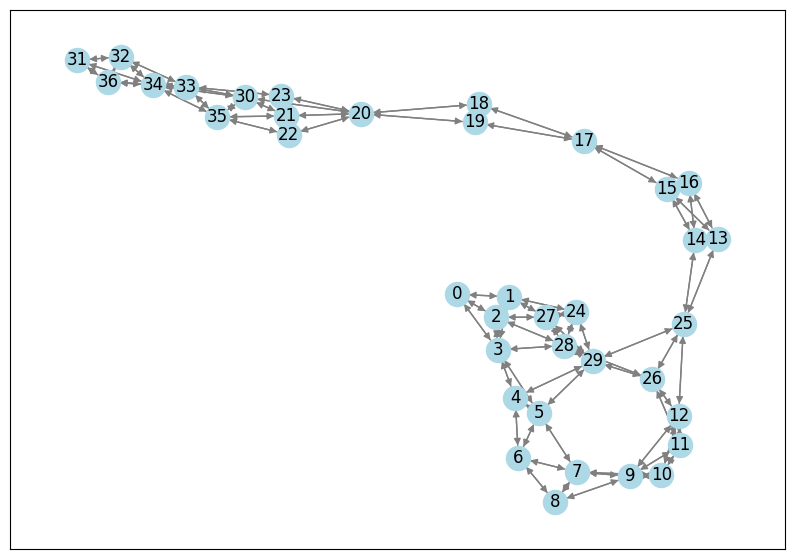

In [25]:
# we show the first graph in the dataset
tuG = to_networkx(tu_ds[0])
plot_graph(tuG)


## Simple node embeddings (Karate club)



/Users/jkunz/Projects/cop_gnn/.venv/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
ic| len(dataset): 1


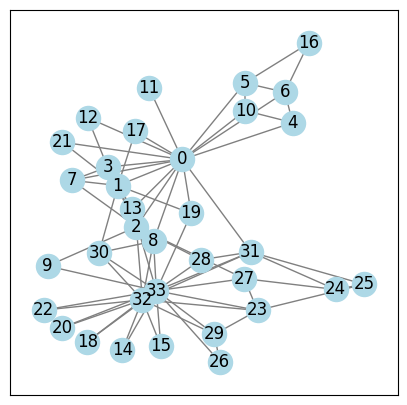

In [50]:
# Load the Zachary Karate Club dataset
dataset = KarateClub()
data = dataset[0]


G = to_networkx(data, to_undirected=True)

plot_graph(G, figsize=(5, 5))
ic(len(dataset));

In [ ]:
# torch geometric -> adjacency matrix
adj_matrix = to_dense_adj(data.edge_index, max_num_nodes=data.num_nodes)
# 3d tensor with batch dimension first
ic(adj_matrix.shape, adj_matrix);

ic| adj_matrix.shape: torch.Size([1, 34, 34])
    adj_matrix: tensor([[[0., 1., 1.,  ..., 1., 0., 0.],
                         [1., 0., 1.,  ..., 0., 0., 0.],
                         [1., 1., 0.,  ..., 0., 1., 0.],
                         ...,
                         [1., 0., 0.,  ..., 0., 1., 1.],
                         [0., 0., 1.,  ..., 1., 0., 1.],
                         [0., 0., 0.,  ..., 1., 1., 0.]]])


In [ ]:
# compute adjacency matrix
num_nodes = data.num_nodes  # 34 nodes
edge_index = data.edge_index  # Edge list
labels = data.y.numpy()  # Community labels (0 or 1)

# Construct adjacency matrix (without self-loops for neighborhood computation)
A = torch.zeros((num_nodes, num_nodes))
A[edge_index[0], edge_index[1]] = 1  # Undirected graph

edge_index[0], edge_index[1]
# matrix is symmetric
A[0,] == A[:, 0]
ic(A.shape,A);

ic| A.shape: torch.Size([34, 34])
    A: tensor([[0., 1., 1.,  ..., 1., 0., 0.],
               [1., 0., 1.,  ..., 0., 0., 0.],
               [1., 1., 0.,  ..., 0., 1., 0.],
               ...,
               [1., 0., 0.,  ..., 0., 1., 1.],
               [0., 0., 1.,  ..., 1., 0., 1.],
               [0., 0., 0.,  ..., 1., 1., 0.]])


In [14]:
i = 0
j = 1
neighbors_i = set(A[i].nonzero(as_tuple=True)[0].tolist())
neighbors_i
A[0].nonzero(as_tuple=True)[0]

tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31])

In [47]:
# Compute Jaccard similarity matrix
def compute_jaccard_similarity(A):
    S = torch.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(i, num_nodes):  # Symmetric matrix, compute upper triangle
            neighbors_i = set(A[i].nonzero(as_tuple=True)[0].tolist())
            neighbors_j = set(A[j].nonzero(as_tuple=True)[0].tolist())
            intersection = len(neighbors_i & neighbors_j)
            union = len(neighbors_i | neighbors_j)
            if union > 0:  # Avoid division by zero
                sim = intersection / union
                S[i, j] = sim
                S[j, i] = sim  # Symmetry
    # No self-loops in Jaccard (typically similarity to self is not 1 unless defined)
    return S

# S = compute_jaccard_similarity(adj_matrix.squeeze(0))  # remove batch dimension
S = compute_jaccard_similarity(A)
print("Jaccard similarity matrix sample:\n", S)  # S[:5, :5])


Jaccard similarity matrix sample:
 tensor([[1.0000, 0.3889, 0.2381,  ..., 0.0000, 0.1200, 0.1379],
        [0.3889, 1.0000, 0.2667,  ..., 0.0714, 0.1053, 0.1304],
        [0.2381, 0.2667, 1.0000,  ..., 0.2308, 0.0476, 0.2857],
        ...,
        [0.0000, 0.0714, 0.2308,  ..., 1.0000, 0.0588, 0.0952],
        [0.1200, 0.1053, 0.0476,  ..., 0.0588, 1.0000, 0.5263],
        [0.1379, 0.1304, 0.2857,  ..., 0.0952, 0.5263, 1.0000]])


In [48]:
# Define the model with embedding lookup
class EmbeddingFactorization(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(EmbeddingFactorization, self).__init__()
        self.embedding = nn.Embedding(num_nodes, embedding_dim)

    def forward(self, node_ids):
        Z = self.embedding(node_ids)
        return Z


# Set up model and optimizer
embedding_dim = 16
node_ids = torch.arange(num_nodes)
model = EmbeddingFactorization(num_nodes=num_nodes, embedding_dim=embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Hyperparameter for L2 regularization
lambda_reg = 0.01  # Regularization strength


# Training function
def train():
    model.train()
    optimizer.zero_grad()

    # Get embeddings
    Z = model(node_ids)

    # Reconstructed similarity: Z Z^T
    S_hat = torch.matmul(Z, Z.t())

    # L2 (Frobenius) loss: ||Z Z^T - S||^2
    recon_loss = torch.norm(S_hat - S, p="fro") ** 2

    # L2 regularization: lambda * ||Z||^2
    l2_reg = lambda_reg * torch.norm(Z, p="fro") ** 2

    loss = recon_loss + l2_reg

    # Backprop
    loss.backward()
    optimizer.step()
    return loss.item()


# Train the model
for epoch in range(5000):
    loss = train()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Get final embeddings
with torch.no_grad():
    Z = model(node_ids)
    Z_np = Z.numpy()
    print("Final embeddings shape:", Z.shape)
    print("Sample embeddings:\n", Z[:5])

# Evaluate reconstruction error
S_hat = torch.matmul(Z, Z.t())
reconstruction_error = torch.norm(S_hat - S, p="fro").item()
print(f"Final reconstruction error: {reconstruction_error:.4f}")

Epoch 0, Loss: 24802.4551
Epoch 100, Loss: 1830.3672
Epoch 200, Loss: 517.4395
Epoch 300, Loss: 218.5196
Epoch 400, Loss: 112.1638
Epoch 500, Loss: 64.8328
Epoch 600, Loss: 41.0006
Epoch 700, Loss: 27.8348
Epoch 800, Loss: 19.9758
Epoch 900, Loss: 15.0128
Epoch 1000, Loss: 11.7434
Epoch 1100, Loss: 9.5097
Epoch 1200, Loss: 7.9287
Epoch 1300, Loss: 6.7676
Epoch 1400, Loss: 5.8823
Epoch 1500, Loss: 5.1843
Epoch 1600, Loss: 4.6218
Epoch 1700, Loss: 4.1652
Epoch 1800, Loss: 3.7964
Epoch 1900, Loss: 3.5015
Epoch 2000, Loss: 3.2676
Epoch 2100, Loss: 3.0828
Epoch 2200, Loss: 2.9366
Epoch 2300, Loss: 2.8203
Epoch 2400, Loss: 2.7270
Epoch 2500, Loss: 2.6512
Epoch 2600, Loss: 2.5889
Epoch 2700, Loss: 2.5368
Epoch 2800, Loss: 2.4929
Epoch 2900, Loss: 2.4556
Epoch 3000, Loss: 2.4239
Epoch 3100, Loss: 2.3970
Epoch 3200, Loss: 2.3744
Epoch 3300, Loss: 2.3556
Epoch 3400, Loss: 2.3401
Epoch 3500, Loss: 2.3275
Epoch 3600, Loss: 2.3173
Epoch 3700, Loss: 2.3092
Epoch 3800, Loss: 2.3028
Epoch 3900, Loss: 

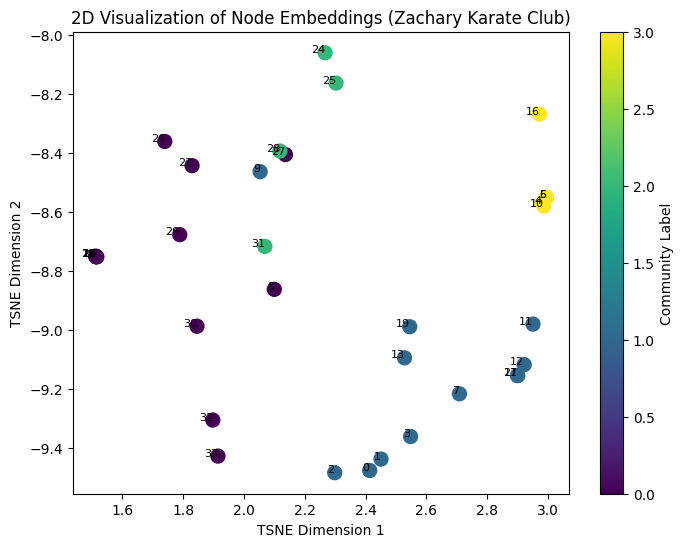

In [49]:
# Reduce embeddings to 2D using TSNE
Z_2d = TSNE(n_components=2, random_state=42).fit_transform(Z_np)

# Visualize in 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=labels, cmap="viridis", s=100)
plt.colorbar(scatter, label="Community Label")
plt.title("2D Visualization of Node Embeddings (Zachary Karate Club)")
plt.xlabel("TSNE Dimension 1")
plt.ylabel("TSNE Dimension 2")
for i in range(num_nodes):  # Optional: label nodes
    plt.text(Z_2d[i, 0], Z_2d[i, 1], str(i), fontsize=8, ha="right")
plt.show()

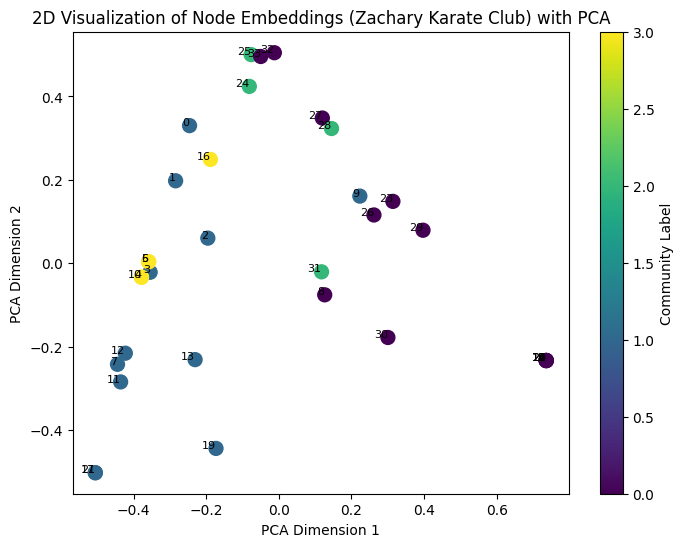

In [45]:
pca = PCA(n_components=2)
Z_2d = pca.fit_transform(Z_np)

# Visualize in 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=labels, cmap="viridis", s=100)
plt.colorbar(scatter, label="Community Label")
plt.title("2D Visualization of Node Embeddings (Zachary Karate Club) with PCA")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
for i in range(num_nodes):  # Optional: label nodes
    plt.text(Z_2d[i, 0], Z_2d[i, 1], str(i), fontsize=8, ha="right")
plt.show()